In [52]:
#!pip install lightgbm
#!pip install shap
# pip install tensorflow_ranking
# pip install tensorflow
# conda install python-graphviz

In [53]:
import os
import shap
import graphviz
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score
from sklearn.model_selection import train_test_split
os.environ["PATH"] += os.pathsep + 'D:/Users/CAIDO/Downloads/graphviz-2.44.1-win32/Graphviz/bin' 

# print the JS visualization code to the notebook
shap.initjs()

## Loading Dataset

In [54]:
data = pd.read_csv("Data_v3.csv", error_bad_lines=False)

In [55]:
data['relevance'] = 0
data.head()

,Unnamed: 0,place_name,place_ID,latitude,Longitude,plus_code,rating,user_ratings_total,business_status,types,address,region,population,num_bus_stop,num_mall,relevance
0,0,NTU North Spine Plaza,ChIJ-f-vxgoP2jERP42l8kUV8DE,1.347064,103.680822,8MWJ+R8 Singapore,4.3,1070,OPERATIONAL,shopping_mall,"76 Nanyang Dr, Singapore 637331",Western Water Catchment,NaN,18,0,0
1,1,Orchard Towers,ChIJ-z0z0IwZ2jERXjOtNGbV0-0,1.307229,103.829332,8R4H+VP Singapore,3.9,2292,OPERATIONAL,shopping_mall,"400 Orchard Rd, Singapore 238875",Orchard,920.0,7,13,0
2,2,Quayside Isle,ChIJ01fgzLUe2jERxlhvImcbZ7g,1.247681,103.842072,6RXR+3R Singapore,4.3,568,OPERATIONAL,shopping_mall,"31 Ocean Way, Singapore 098375",Southern Islands,1480.0,1,0,0
3,3,Coronation Shopping Plaza,ChIJ08duKAYa2jER47-5U4ZdgAo,1.323919,103.809989,8RF5+HX Singapore,3.6,202,OPERATIONAL,shopping_mall,"587 Bukit Timah Rd, Singapore 269707",Bukit Timah,74470.0,7,4,0
4,4,Hougang 1,ChIJ0ZkQLVsW2jERY9DgZurtpl8,1.376061,103.879155,9VGH+CM Singapore,3.9,2183,OPERATIONAL,shopping_mall,"1 Hougang Street 91, Singapore 538692",Hougang,222310.0,0,0,0


In [56]:
pd.options.mode.chained_assignment = None
data['population']=data['population'].fillna(0)

for i in range(len(data)):
    if data['user_ratings_total'][i] >= 100:
        data['relevance'][i] = data['rating'][i]
    elif data['user_ratings_total'][i] >= 50:
        data['relevance'][i] = 0.85*data['rating'][i]
    else:
        data['relevance'][i] = 0.7*data['rating'][i]

In [57]:
X = data[['latitude', 'Longitude', 'population', 'num_bus_stop', 'num_mall']]
Y = data['relevance'].astype(int)
Y

0      4
1      3
2      4
3      3
4      3
      ..
326    4
327    4
328    3
329    3
330    4
Name: relevance, Length: 331, dtype: int32

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [59]:
query_train = [X_train.shape[0]]
query_val   = [X_val.shape[0]]
query_test  = [X_test.shape[0]]

In [60]:
gbm = lgb.LGBMRanker(learning_rate = 0.01, objective = 'lambdarank')

## Train The Model

<p>Implement LambdaMART using lightgbm: https://github.com/guolinke/boosting_tree_benchmarks/tree/master/data</p>

In [61]:
gbm = lgb.LGBMRanker(learning_rate = 0.01, objective = 'lambdarank')

In [62]:
gbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.01,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'lambdarank',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [63]:
# gbm.fit(X_train, y_train, group=query_train,
#         eval_set=[(X_val, y_val)], eval_group=[query_val],
#         eval_at=[5, 10, 20], early_stopping_rounds=50)

res = {}
result = gbm.fit(X_train, y_train, group=query_train, verbose=10,
        eval_set=[(X_val, y_val)], eval_group=[query_val],
        eval_at=[5, 10, 20])

[10]	valid_0's ndcg@5: 0.909557	valid_0's ndcg@10: 0.941309	valid_0's ndcg@20: 0.86872
[20]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 0.96297	valid_0's ndcg@20: 0.901996
[30]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 0.910524	valid_0's ndcg@20: 0.898856
[40]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 0.910524	valid_0's ndcg@20: 0.898856
[50]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 0.907378	valid_0's ndcg@20: 0.896826
[60]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 0.910524	valid_0's ndcg@20: 0.898856
[70]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 0.907378	valid_0's ndcg@20: 0.896826
[80]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 0.941309	valid_0's ndcg@20: 0.906876
[90]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 0.944455	valid_0's ndcg@20: 0.908247
[100]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 0.949103	valid_0's ndcg@20: 0.903283


### Predict
<p> This numbers can be interpreted as probabilities of a item being relevant (or being at the top) </p>

In [64]:
test_pred = gbm.predict(X_test)
test_pred

array([-0.30003112, -0.85663132, -0.38777306,  0.56836608,  0.54500755,
       -0.27410538, -0.59391618,  0.61013897, -0.47891101, -0.82018707,
       -0.35671571, -0.17593327, -0.71372371, -0.32787564, -0.32193643,
       -0.04352709, -0.27896952,  0.14116159, -0.56174626, -0.78025878,
       -0.38509424, -0.82677155, -0.09754779, -0.79288829,  0.56836608,
        0.61013897, -0.34195   ,  0.38486891,  0.21165845, -0.02173215,
        0.25181958, -0.6615276 ,  0.41151727, -0.04352709,  0.21890933,
       -0.09309046, -0.91825254, -0.25843628, -0.48131966,  0.21165845,
       -0.19846745, -0.37766907, -0.45302174, -0.63706779,  0.40491331,
       -0.38893962,  0.9676497 , -0.61344363, -0.97776349, -0.31090918,
        0.18773093, -0.22036393, -0.79898582,  0.74560255, -0.87841944,
       -0.27896952,  0.52300954, -0.92440012,  0.28333907, -0.36885757,
       -0.5912014 , -0.62843383,  0.23347943,  0.28333907, -0.77175763,
        0.20739462, -0.54914473])

In [65]:
show = pd.DataFrame({'Latitude': X_test["latitude"], 'Longitude': X_test["Longitude"], 'True Relevance': y_test, 'Predicted Ranking': test_pred}).sort_values(by='Predicted Ranking', ascending=False)
show.reset_index(drop = True, inplace=True)
pd.set_option('display.max_rows', len(y_test))
show

,Latitude,Longitude,True Relevance,Predicted Ranking
0,1.295030,103.858303,4,0.967650
1,1.293758,103.853433,4,0.745603
2,1.360524,103.953166,4,0.610139
3,1.354464,103.960012,4,0.610139
4,1.379798,103.936267,3,0.568366
5,1.372417,103.949658,3,0.568366
6,1.394228,103.913016,3,0.545008
7,1.298889,103.855556,4,0.523010
8,1.298083,103.844098,3,0.411517
9,1.279186,103.848844,2,0.404913


In [66]:
prob = show['Predicted Ranking']
map_score = []
for i in range(len(prob)):
    if prob[i]>0.6:
        map_score.append(5)
    elif prob[i]>0.2:
        map_score.append(4)
    elif prob[i]>-0.2: 
        map_score.append(3)
    elif prob[i]>-0.6: 
        map_score.append(2)
    elif prob[i]>-1: 
        map_score.append(1)
show['Map Score'] = map_score
show

,Latitude,Longitude,True Relevance,Predicted Ranking,Map Score
0,1.295030,103.858303,4,0.967650,5
1,1.293758,103.853433,4,0.745603,5
2,1.360524,103.953166,4,0.610139,5
3,1.354464,103.960012,4,0.610139,5
4,1.379798,103.936267,3,0.568366,4
5,1.372417,103.949658,3,0.568366,4
6,1.394228,103.913016,3,0.545008,4
7,1.298889,103.855556,4,0.523010,4
8,1.298083,103.844098,3,0.411517,4
9,1.279186,103.848844,2,0.404913,4


### Evaluation
<p> Use nDCG@k to evaluate the ranking our model </p> 

In [67]:
def ndcg(y_test, y_pred):
    ndcg_5 = ndcg_score(np.asarray([y_test]), np.asarray([y_pred]), k=5)
    ndcg_10 = ndcg_score(np.asarray([y_test]), np.asarray([y_pred]), k=10)
    ndcg_20 = ndcg_score(np.asarray([y_test]), np.asarray([y_pred]), k=20)
    print('NDCG@5 = {}'.format(ndcg_5))
    print('NDCG@10 = {}'.format(ndcg_10))
    print('NDCG@20 = {}'.format(ndcg_20))

In [68]:
ndcg(y_test, test_pred)

NDCG@5 = 0.9671987306219144
NDCG@10 = 0.8923997228570129
NDCG@20 = 0.8697220913893661


## Explain Prediction

<p>Here we use the Tree SHAP implementation integrated into Light GBM to explain the entire dataset 

In [69]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X)

### SHAP Summary Plot

<p>Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. 

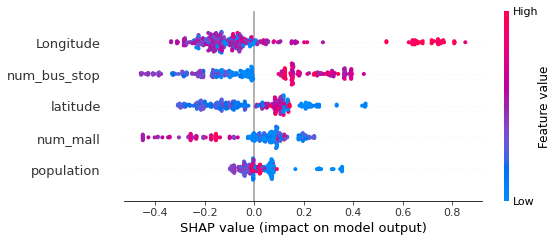

In [70]:
shap.summary_plot(shap_values, X)

More than one metric available, picking one to plot.


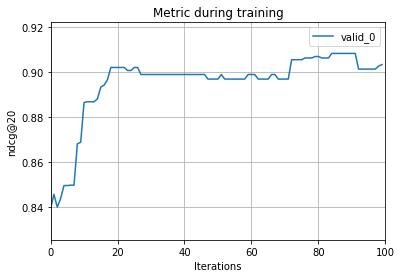

In [71]:
lgb.plot_metric(gbm)

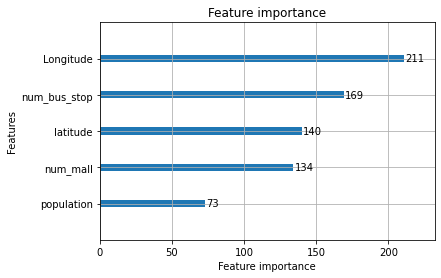

In [72]:
lgb.plot_importance(gbm)

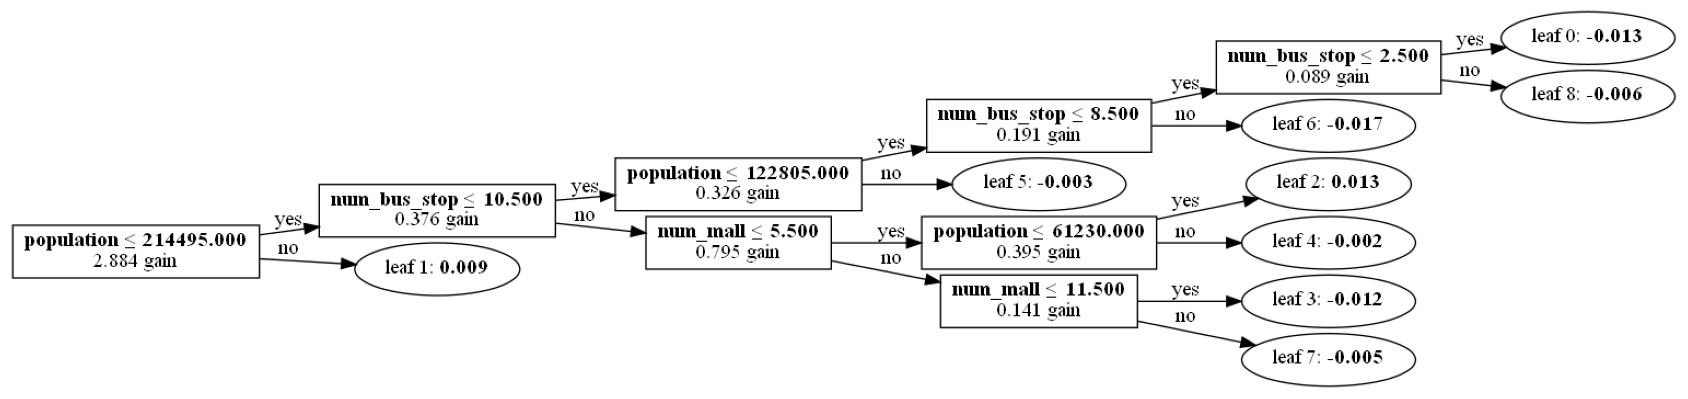

In [73]:
lgb.plot_tree(gbm, tree_index=1, figsize=(30, 8), show_info=['split_gain'])